In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [2]:
file_path = '/content/data.csv'
data = pd.read_csv(file_path)

In [3]:
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# Define the Gaussian Process Regressor
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-3, 1e3))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-10)

In [7]:
# Define the hyperparameters grid
param_grid = {
    'alpha': [1e-10, 1e-5, 1e-2, 1e-1, 1.0],                                                               #Adjusts the noise level in the Gaussian Process.
    'n_restarts_optimizer': [0, 5, 10],                                                                    #Controls the number of optimizer restarts to avoid local minima.
    'kernel': [C(1.0, (1e-2, 1e2)) * RBF(length_scale, (1e-2, 1e2)) for length_scale in [0.1, 1.0, 10.0]]  #Defines different combinations of ConstantKernel & RBF kernels with varying length scales.
}

In [8]:
# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(estimator=gpr, param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2')
grid_search.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                                                n_restarts_optimizer=10),
             n_jobs=-1,
             param_grid={'alpha': [1e-10, 1e-05, 0.01, 0.1, 1.0],
                         'kernel': [1**2 * RBF(length_scale=0.1),
                                    1**2 * RBF(length_scale=1),
                                    1**2 * RBF(length_scale=10)],
                         'n_restarts_optimizer': [0, 5, 10]},
             scoring='r2')

In [9]:
# Get the best model
best_gpr = grid_search.best_estimator_

In [10]:
# Make predictions on the testing set
y_pred, sigma = best_gpr.predict(X_test, return_std=True)

In [11]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [12]:
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")
print(f"Best Parameters: {grid_search.best_params_}")

Mean Squared Error: 0.007270558783435072
R^2 Score: -0.0017560278037751509
Best Parameters: {'alpha': 0.1, 'kernel': 1**2 * RBF(length_scale=0.1), 'n_restarts_optimizer': 5}


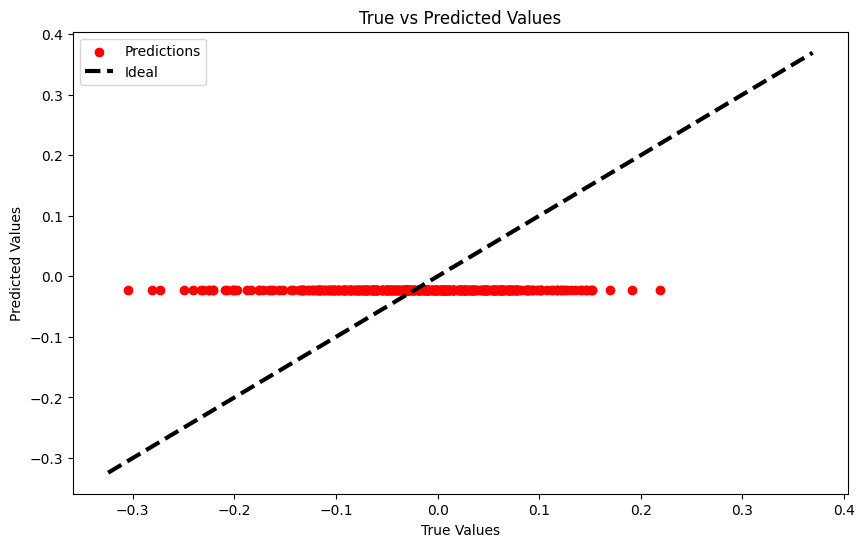

In [13]:
# Plot the predictions vs true values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, c='r', marker='o', label='Predictions')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3, label='Ideal')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.legend()
plt.show()

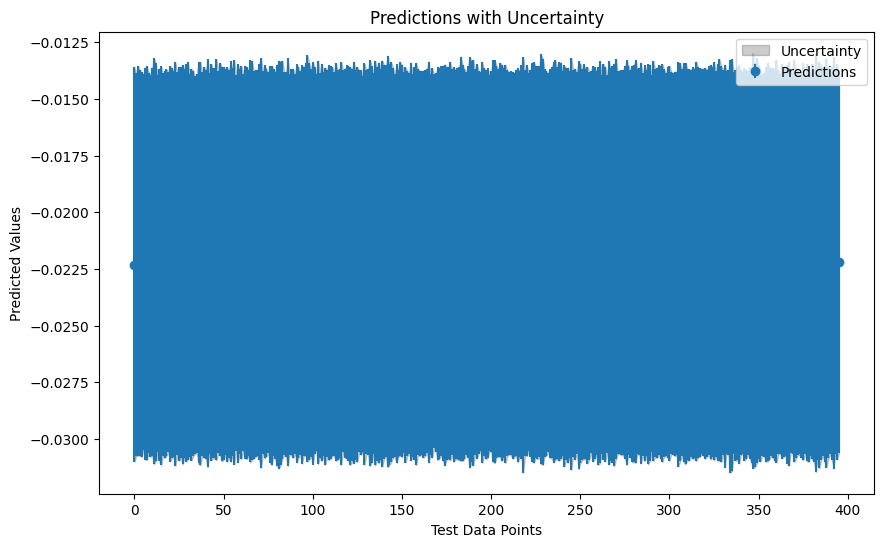

In [14]:
# Plot the prediction uncertainty
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(y_test)), y_pred, yerr=sigma, fmt='o', label='Predictions')
plt.fill_between(range(len(y_test)), y_pred - sigma, y_pred + sigma, alpha=0.2, color='k', label='Uncertainty')
plt.xlabel('Test Data Points')
plt.ylabel('Predicted Values')
plt.title('Predictions with Uncertainty')
plt.legend()
plt.show()